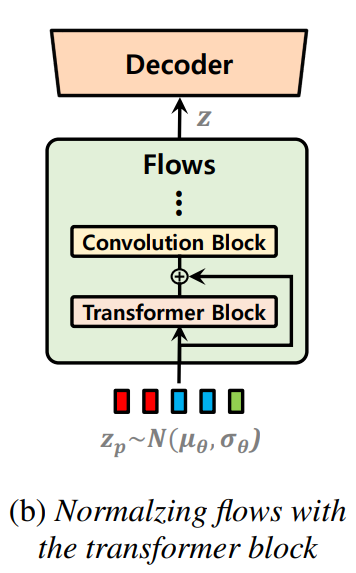

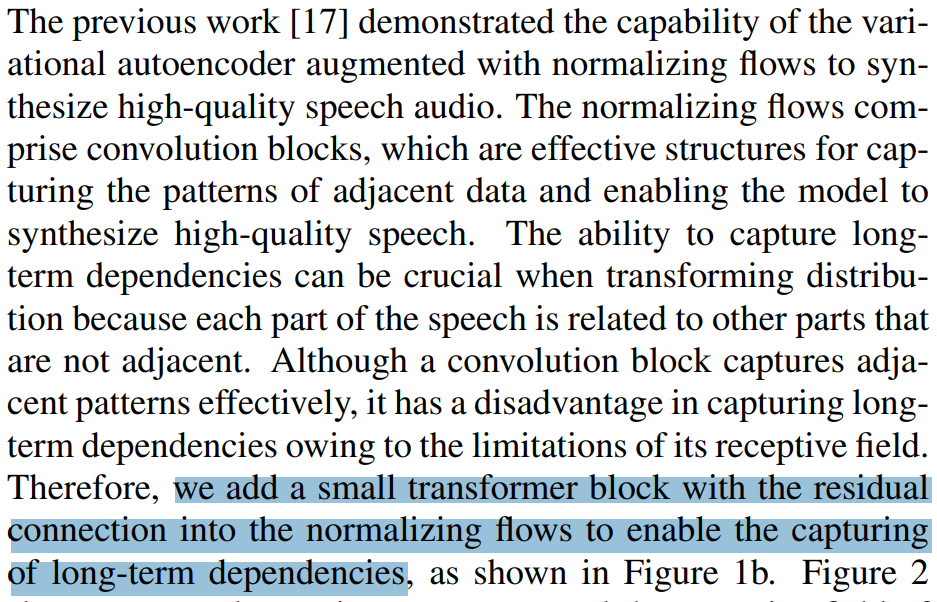

<p> I might be completely wrong, but I just added transformers before the conv layer in residual flows before calculating the flow stats. I have tested that they are completely invertible. However, I think the authors want to add trasnformer on the output of the upsampled hidden text features. I am not sure if that is possible because the stats of that flow are calculated before the transformers. I would be happy to discuss in detail if anyone is interested. Please let me know if I am wrong. Thanks!

In [1]:
import os
os.chdir(r'../../vits2_pytorch')

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from models import SynthesizerTrn
from modules import *
import modules
import attentions

In [3]:
n_vocab=256
spec_channels=80 # mel-spectrogram channels vits2 (vits1 used 513)
segment_size=8192
inter_channels=192
hidden_channels=192
filter_channels=768
n_heads=2
n_layers=6
kernel_size=3
p_dropout=0.1
resblock="1" 
resblock_kernel_sizes=[3, 7, 11]
resblock_dilation_sizes=[[1, 3, 5], [1, 3, 5], [1, 3, 5]]
upsample_rates=[8, 8, 2, 2]
upsample_initial_channel=512
upsample_kernel_sizes=[16, 16, 4, 4]
n_speakers=0
gin_channels=0
use_sdp=True

### Implementation style 1 (pre-convolution)

In [50]:
class ResidualCouplingTransformersLayer(nn.Module):
  def __init__(
      self,
      channels,
      hidden_channels,
      kernel_size,
      dilation_rate,
      n_layers,
      p_dropout=0,
      gin_channels=0,
      mean_only=False,
  ):
      assert channels % 2 == 0, "channels should be divisible by 2"
      super().__init__()
      self.channels = channels
      self.hidden_channels = hidden_channels
      self.kernel_size = kernel_size
      self.dilation_rate = dilation_rate
      self.n_layers = n_layers
      self.half_channels = channels // 2
      self.mean_only = mean_only
      #vits2
      self.pre_transformer = attentions.Encoder(
          self.half_channels,
          self.half_channels,
          n_heads=2,
          n_layers=2,
          kernel_size=3,
          p_dropout=0.1,
          window_size=None
          )
      
      self.pre = nn.Conv1d(self.half_channels, hidden_channels, 1)
      self.enc = modules.WN(
          hidden_channels,
          kernel_size,
          dilation_rate,
          n_layers,
          p_dropout=p_dropout,
          gin_channels=gin_channels,
      )
      #vits2
      self.post_transformer = attentions.Encoder( 
          self.hidden_channels,
          self.hidden_channels,
          n_heads=2,
          n_layers=2,
          kernel_size=3,
          p_dropout=0.1,
          window_size=None
          )
      
      self.post = nn.Conv1d(hidden_channels, self.half_channels * (2 - mean_only), 1)
      self.post.weight.data.zero_()
      self.post.bias.data.zero_()

  def forward(self, x, x_mask, g=None, reverse=False):
      x0, x1 = torch.split(x, [self.half_channels] * 2, 1)
      x0_ = self.pre_transformer(x0 * x_mask, x_mask) #vits2
      x0_ = x0_ + x0 #vits2 residual connection
      h = self.pre(x0_) * x_mask #changed from x0 to x0_ to retain x0 for the flow
      h = self.enc(h, x_mask, g=g)
    
      #vits2 - (experimental;uncomment the following 2 line to use)
      # h_ = self.post_transformer(h, x_mask) 
      # h = h + h_ #vits2 residual connection 
      
      stats = self.post(h) * x_mask
      if not self.mean_only:
          m, logs = torch.split(stats, [self.half_channels] * 2, 1)
      else:
          m = stats
          logs = torch.zeros_like(m)
      if not reverse:
          x1 = m + x1 * torch.exp(logs) * x_mask
          x = torch.cat([x0, x1], 1)
          logdet = torch.sum(logs, [1, 2])
          return x, logdet
      else:
          x1 = (x1 - m) * torch.exp(-logs) * x_mask
          x = torch.cat([x0, x1], 1)
          return x

In [51]:
#  'channels', 'hidden_channels', 'kernel_size', 'dilation_rate', and 'n_layers
test_flow_layer = ResidualCouplingTransformersLayer(
    inter_channels, hidden_channels, 5, 1, 4
)

In [52]:
# test with random data
x = torch.randn(1, 192, 5)
x_mask = torch.ones(1, 1, 5)


In [53]:
flowop = test_flow_layer(x, x_mask)
# revese flow
rev_flowop = test_flow_layer(flowop[0], x_mask, reverse=True)
(rev_flowop == x).sum() == x.numel() # flow works.

tensor(True)

### Implementation style 2: below is another way to do it from the [so-vits-svc](https://github.com/svc-develop-team/so-vits-svc/commit/fc8336fffd40c39bdb225c1b041ab4dd15fac4e9) repo 

In [44]:
class FFTransformerCouplingLayer(nn.Module):
  def __init__(self,
      channels,
      hidden_channels,
      kernel_size,
      n_layers,
      n_heads,
      p_dropout=0,
      filter_channels=768,
      mean_only=False,
      gin_channels = 0
      ):
    assert channels % 2 == 0, "channels should be divisible by 2"
    super().__init__()
    self.channels = channels
    self.hidden_channels = hidden_channels
    self.kernel_size = kernel_size
    self.n_layers = n_layers
    self.half_channels = channels // 2
    self.mean_only = mean_only

    self.pre = nn.Conv1d(self.half_channels, hidden_channels, 1)
    self.enc = attentions.FFT(
       hidden_channels, 
       filter_channels, 
       n_heads, 
       n_layers, 
       kernel_size, 
       p_dropout, 
       isflow = True, 
       gin_channels = gin_channels
       )
    self.post = nn.Conv1d(hidden_channels, self.half_channels * (2 - mean_only), 1)
    self.post.weight.data.zero_()
    self.post.bias.data.zero_()

  def forward(self, x, x_mask, g=None, reverse=False):
    x0, x1 = torch.split(x, [self.half_channels]*2, 1)
    h = self.pre(x0) * x_mask
    h_ = self.enc(h, x_mask, g=g)
    h = h_ + h
    stats = self.post(h) * x_mask
    if not self.mean_only:
      m, logs = torch.split(stats, [self.half_channels]*2, 1)
    else:
      m = stats
      logs = torch.zeros_like(m)

    if not reverse:
      x1 = m + x1 * torch.exp(logs) * x_mask
      x = torch.cat([x0, x1], 1)
      logdet = torch.sum(logs, [1,2])
      return x, logdet
    else:
      x1 = (x1 - m) * torch.exp(-logs) * x_mask
      x = torch.cat([x0, x1], 1)
      return x

In [45]:
test_flow_layer_2 = FFTransformerCouplingLayer(
    inter_channels, hidden_channels, 5, 1, 4
)

In [29]:
flowop = test_flow_layer_2(x, x_mask)
# revese flow
rev_flowop = test_flow_layer_2(flowop[0], x_mask, reverse=True)
(rev_flowop == x).sum() == x.numel() # flow works.

tensor(True)

#### Implementation Style 3 : Closest to the intended architecture design

In [40]:
class MonoTransformerFlowLayer(nn.Module):
    def __init__(
        self,
        channels,
        hidden_channels,
        mean_only=False,
    ):
        assert channels % 2 == 0, "channels should be divisible by 2"
        super().__init__()
        self.channels = channels
        self.hidden_channels = hidden_channels
        self.half_channels = channels // 2
        self.mean_only = mean_only
        #vits2
        self.pre_transformer = attentions.Encoder(
            self.half_channels,
            self.half_channels,
            n_heads=2,
            n_layers=2,
            kernel_size=3,
            p_dropout=0.1,
            window_size=None
            )
        
        self.post = nn.Conv1d(self.half_channels, self.half_channels * (2 - mean_only), 1)
        self.post.weight.data.zero_()
        self.post.bias.data.zero_()

    def forward(self, x, x_mask, g=None, reverse=False):
        x0, x1 = torch.split(x, [self.half_channels] * 2, 1)
        x0_ = self.pre_transformer(x0 * x_mask, x_mask) #vits2
        h = x0_ + x0 #vits2
        stats = self.post(h) * x_mask
        if not self.mean_only:
            m, logs = torch.split(stats, [self.half_channels] * 2, 1)
        else:
            m = stats
            logs = torch.zeros_like(m)
        if not reverse:
            x1 = m + x1 * torch.exp(logs) * x_mask
            x = torch.cat([x0, x1], 1)
            logdet = torch.sum(logs, [1, 2])
            return x, logdet
        else:
            x1 = (x1 - m) * torch.exp(-logs) * x_mask
            x = torch.cat([x0, x1], 1)
            return x

In [41]:
#  'channels', 'hidden_channels', 'kernel_size', 'dilation_rate', and 'n_layers
test_flow_layer_3 = MonoTransformerFlowLayer(
    inter_channels, hidden_channels
)

In [42]:
# test with random data
x = torch.randn(1, 192, 5)
x_mask = torch.ones(1, 1, 5)

In [43]:
flowop = test_flow_layer_3(x, x_mask)
# revese flow
rev_flowop = test_flow_layer_3(flowop[0], x_mask, reverse=True)
(rev_flowop == x).sum() == x.numel() # flow works.

tensor(True)

In [9]:
# sanity check
net_g = SynthesizerTrn(
    n_vocab=256,
    spec_channels=80,
    segment_size=8192,
    inter_channels=192,
    hidden_channels=192,
    filter_channels=768,
    n_heads=2,
    n_layers=6,
    kernel_size=3,
    p_dropout=0.1,
    resblock="1", 
    resblock_kernel_sizes=[3, 7, 11],
    resblock_dilation_sizes=[[1, 3, 5], [1, 3, 5], [1, 3, 5]],
    upsample_rates=[8, 8, 2, 2],
    upsample_initial_channel=512,
    upsample_kernel_sizes=[16, 16, 4, 4],
    n_speakers=0,
    gin_channels=0,
    use_sdp=True,
    use_transformer_flows=True,
    transformer_flow_type="mono_layer",
    use_spk_conditioned_encoder=True,
)

In [14]:
# test with random data
x = torch.randn(1, 192, 5)
x_mask = torch.ones(1, 1, 5)
flowop = net_g.flow(x, x_mask)
# revese flow
rev_flowop = net_g.flow(flowop, x_mask, reverse=True)
(rev_flowop == x).sum() == x.numel() # flow works.

tensor(True)

In [ ]:
x = torch.LongTensor([[1, 2, 3],[4, 5, 6]])
x_lengths = torch.LongTensor([3, 2])
y = torch.randn(2, 80, 100)
y_lengths = torch.Tensor([100, 80])


net_g(
    x=x,
    x_lengths=x_lengths,
    y=y,
    y_lengths=y_lengths,
)